In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
from concurrent import futures
import threading
from sklearn.model_selection import train_test_split
from collections import Counter

In [3]:
#Load Training Dataset

root ="/content/gdrive/My Drive/Gender_class/Dataset/train data"

# read dataset
base_dir = os.path.join(root)
females = os.path.join(base_dir,'females')
males = os.path.join(base_dir,'males')

females_files = glob.glob(females+'/*.png')
males_files = glob.glob(males+'/*.png')
len(females_files), len(males_files)

(1071, 1109)

In [4]:
#Check top 5 rows of training data
np.random.seed(42)

files_df = pd.DataFrame({
    'filename': females_files + males_files,
    'label': ['Female'] * len(females_files) + ['male'] * len(males_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,/content/gdrive/My Drive/Gender_class/Dataset/...,Female
1,/content/gdrive/My Drive/Gender_class/Dataset/...,Female
2,/content/gdrive/My Drive/Gender_class/Dataset/...,Female
3,/content/gdrive/My Drive/Gender_class/Dataset/...,male
4,/content/gdrive/My Drive/Gender_class/Dataset/...,Female


In [5]:
#Load Validation Dataset

root ="/content/gdrive/My Drive/Gender_class/Dataset/valid data"

# read dataset
base_dir = os.path.join(root)
v_females = os.path.join(base_dir,'female')
v_males = os.path.join(base_dir,'male')

v_females_files = glob.glob(v_females+'/*.png')
v_males_files = glob.glob(v_males+'/*.png')
len(v_females_files), len(v_males_files)

(454, 467)

In [6]:
#Check top 5 rows of data
np.random.seed(42)

v_files_df = pd.DataFrame({
    'filename': v_females_files + v_males_files,
    'label': ['Female'] * len(v_females_files) + ['male'] * len(v_males_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

v_files_df.head()

,filename,label
0,/content/gdrive/My Drive/Gender_class/Dataset/...,Female
1,/content/gdrive/My Drive/Gender_class/Dataset/...,Female
2,/content/gdrive/My Drive/Gender_class/Dataset/...,male
3,/content/gdrive/My Drive/Gender_class/Dataset/...,Female
4,/content/gdrive/My Drive/Gender_class/Dataset/...,male


In [7]:
train_files = files_df['filename'].values
train_labels = files_df['label'].values

val_files = v_files_df['filename'].values
val_labels = v_files_df['label'].values

print(train_files.shape, val_files.shape)
print('Train:', Counter(train_labels), '\nValidation:', Counter(val_labels))

(2180,) (921,)
Train: Counter({'male': 1109, 'Female': 1071}) 
Validation: Counter({'male': 467, 'Female': 454})


In [8]:
#resize images 
IMG_DIMS = (100, 100)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    # Apply bilateral filter with d = 15,  
    # sigmaColor = sigmaSpace = 75.
    #img = cv2.bilateralFilter(img, 3, 7, 9) 
    img = cv2.resize(img, dsize=IMG_DIMS, interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

train_data.shape, val_data.shape

Loading Train Images:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_1: working on img num: 2179

Loading Validation Images:
ThreadPoolExecutor-0_5: working on img num: 0
ThreadPoolExecutor-0_7: working on img num: 920


((2180, 100, 100, 3), (921, 100, 100, 3))

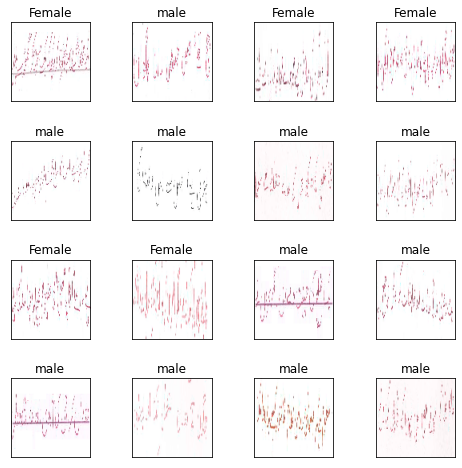

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [10]:
BATCH_SIZE = 32
NUM_CLASSES = 2
EPOCHS = 25
INPUT_SHAPE = (100, 100, 3)



#scale data
train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

# encode text category labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)
print(train_labels[:6], train_labels_enc[:6])

['Female' 'Female' 'Female' 'male' 'Female' 'Female'] [0 0 0 1 0 0]


Labels: ['Female', 'Female', 'Female', 'Female', 'Female']


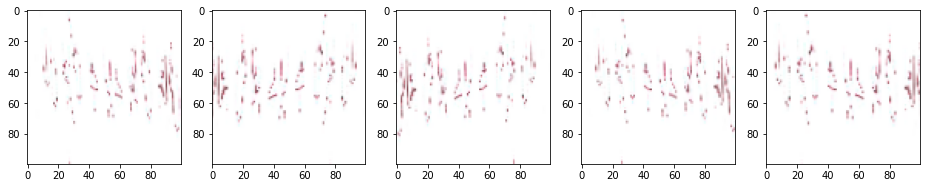

In [11]:
import tensorflow as tf
# Load the TensorBoard notebook extension (optional)
%load_ext tensorboard

#tf.random.set_random_seed(42)
tf.random.set_seed(42)
tf.__version__

#Applying Data augmentation to images

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                rotation_range=2, 
                                                                horizontal_flip=True,
                                                                zoom_range=.1)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                rotation_range=2, 
                                                                horizontal_flip=True,
                                                                zoom_range=.1)
# check augmented images
img_id = 0
sample_generator = train_datagen.flow(train_data[img_id:img_id+1], train_labels[img_id:img_id+1],
                                      batch_size=1)
sample = [next(sample_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in sample])
l = [ax[i].imshow(sample[i][0][0]) for i in range(0,5)]

# build image augmentation generators
train_generator = train_datagen.flow(train_data, train_labels_enc, batch_size=BATCH_SIZE, shuffle=True)
val_generator = val_datagen.flow(val_data, val_labels_enc, batch_size=BATCH_SIZE, shuffle=False)


**VGG-16 model training**

In [21]:
#Load pretrained model without any weights
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)

# Freeze the layers
vgg.trainable = True

set_trainable = False
for layer in vgg.layers:
    if layer.name in ['block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False    
base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(1024, activation='relu')(pool_out)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(hidden1)
hidden3 = tf.keras.layers.Dense(256, activation='relu')(hidden2)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden3)
hidden4 = tf.keras.layers.Dense(64, activation='relu')(drop2)
out = tf.keras.layers.Dense(1, activation='sigmoid')(hidden4)

model = tf.keras.Model(inputs=base_vgg.input, outputs=out)

learn_rate=.01

#sgd=tf.keras.optimizers.SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
#rms = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(tf.keras.optimizers.SGD(learning_rate=learn_rate,momentum=.9,nesterov=False),
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()


print("Total Layers:", len(model.layers))
print("Total trainable layers:", sum([1 for l in model.layers if l.trainable]))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0   

In [23]:
lrr= tf.keras.callbacks.ReduceLROnPlateau(
                       monitor='val_accuracy', #Metric to be measured
                       factor=.01, #Factor by which learning rate will be reduced
                       patience=2,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-5) #The minimum learning rate

train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size
history = model.fit(train_generator,
                      epochs=EPOCHS,
                      steps_per_epoch=train_steps_per_epoch,
                      validation_data=val_generator,
                      validation_steps=val_steps_per_epoch,
                      callbacks=[lrr],verbose=1)

Epoch 1/25
68/68 [==============================] - 10s 134ms/step - loss: 0.6944 - accuracy: 0.5335 - val_loss: 0.6927 - val_accuracy: 0.5100 - lr: 0.0100
Epoch 2/25
68/68 [==============================] - 9s 129ms/step - loss: 0.7036 - accuracy: 0.5144 - val_loss: 0.6930 - val_accuracy: 0.5100 - lr: 0.0100
Epoch 3/25
68/68 [==============================] - 9s 129ms/step - loss: 0.6714 - accuracy: 0.5875 - val_loss: 0.7048 - val_accuracy: 0.5513 - lr: 0.0100
Epoch 4/25
68/68 [==============================] - 11s 158ms/step - loss: 0.6488 - accuracy: 0.6187 - val_loss: 0.7432 - val_accuracy: 0.5725 - lr: 0.0100
Epoch 5/25
68/68 [==============================] - 9s 130ms/step - loss: 0.6370 - accuracy: 0.6439 - val_loss: 0.8811 - val_accuracy: 0.4978 - lr: 0.0100
Epoch 6/25
68/68 [==============================] - 9s 129ms/step - loss: 0.7085 - accuracy: 0.5102 - val_loss: 0.6945 - val_accuracy: 0.4900 - lr: 0.0100
Epoch 7/25
68/68 [==============================] - 9s 131ms/step - 

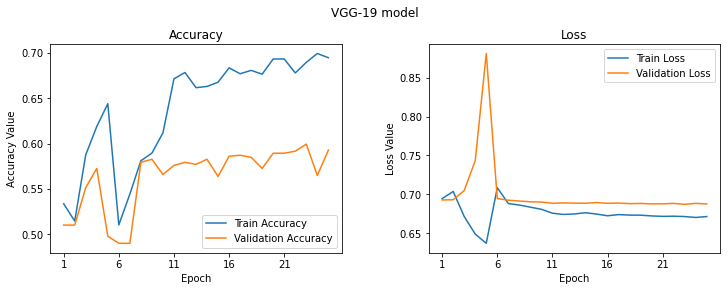

In [24]:
#plot accuracy and loss of trained model on training and validation data
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('VGG-19 model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [25]:
model.save('GenderClassificationVgg16.h5')